# Twitter Bot Account Classification with Ludwig AutoML


This notebook demonstrates how to use Ludwig, an AutoML framework, for classifying Twitter accounts into binary classes based on multiple features.

We'll install dependencies, define our model configuration, train the model, and visualize performance metrics.

In [1]:
#!nvidia-smi -L

In [2]:
# Disable GPU

#import os

#os.environ["CUDA_VISIBLE_DEVICES"]="GPU-XXXXX" # MIG-GPU-XXXXX

#os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
!pip install ludwig scikit-learn==1.2.2

!pip install torch==2.1.0 torchaudio==2.1.0 torchvision==0.16.0 torchtext==0.16.0

!pip install accelerate -U

!pip install ptitprince

!pip install numpy==1.26.4

!pip install matplotlib==3.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 9.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.7 MB

In [4]:
import pandas as pd

import logging

from ludwig.api import LudwigModel

from ludwig.visualize import confusion_matrix, learning_curves


# Define the configuration for the Ludwig model

config = {

  "input_features": [

    {"name": "default_profile", "type": "binary"},

    {"name": "default_profile_image", "type": "binary"},

    {"name": "description", "type": "text"},

    {"name": "favourites_count", "type": "number"},

    {"name": "followers_count", "type": "number"},

    {"name": "friends_count", "type": "number"},

    {"name": "geo_enabled", "type": "binary"},

    {"name": "lang", "type": "category"},

    {"name": "location", "type": "category"},

    {"name": "profile_background_image_path", "type": "category"},

    {"name": "profile_image_path", "type": "image"},

    {"name": "statuses_count", "type": "number"},

    {"name": "verified", "type": "binary"},

    {"name": "average_tweets_per_day", "type": "number"},

    {"name": "account_age_days", "type": "number"},

  ],

  "output_features": [

    {"name": "account_type", "type": "binary"}

  ],

  'trainer': {'epochs': 100, 'optimizer': {'type': 'adam'}, 'batch_size': 16},

}


2024-11-09 21:53:49,570	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-09 21:53:49,984	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
# Load the Twitter dataset

dataset_df = pd.read_csv("/kaggle/input/twitter-human-bots-dataset/twitter_human_bots_dataset.csv")


# Append full path to image data

dataset_df['profile_image_path'] = '/kaggle/input/twitter-human-bots-dataset/' + dataset_df['profile_image_path']


# Display the first few rows of the dataset

dataset_df.head()

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,...,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,profile_image_path,profile_background_image_path,split
0,0,2009-07-04 22:41:51,False,False,NaN,5007,102,168,False,53779179,...,https://pbs.twimg.com/profile_images/128969130...,paty_castroo,3974,False,0.978,4063,bot,NaN,NaN,0
1,1,2010-01-17 22:54:19,False,False,Television producer. Emmy Award winner. Disney...,1038,60,128,False,105916557,...,https://pbs.twimg.com/profile_images/632916759...,CBirckner,259,False,0.067,3866,human,/kaggle/input/twitter-human-bots-dataset/profi...,profile_images/4691ae58668d932bb7e7af22141aecf...,0
2,2,2012-03-01 06:05:32,False,False,NaN,2257,599,449,True,509788597,...,https://pbs.twimg.com/profile_images/128853844...,amf_jay,13627,False,4.406,3093,human,NaN,NaN,0
3,3,2009-09-01 04:52:30,False,False,NaN,6407,116,334,True,70601327,...,https://pbs.twimg.com/profile_images/977012905...,SaraCavolo,4432,False,1.107,4005,human,/kaggle/input/twitter-human-bots-dataset/profi...,profile_images/d1da9220e4aa376dff03b6f12765171...,0
4,4,2010-01-27 17:17:23,False,False,Productor de Televisión - Embajador de @Tienda...,20866,74448,18,True,108999927,...,https://pbs.twimg.com/profile_images/668449819...,DavidHenaoModel,15870,True,4.116,3856,human,/kaggle/input/twitter-human-bots-dataset/profi...,profile_images/c65bf625b066ef5f29e14cfcf1ee91f...,0


In [6]:
# Initialize the model with configuration

model = LudwigModel(config, logging_level=logging.INFO)


# Train the model; this may take some time based on the data size

train_stats, preprocessed_data, output_directory = model.train(dataset=dataset_df)

/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1735: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1744: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1735: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/utils/image_utils.py:185: UserWarning: Failed to read image from numpy file. Original exception: Cannot load file

Training:   6%|▌         | 9828/163800 [04:28<1:10:11, 36.56it/s, loss=0.0922]


In [7]:
# Split the dataset for testing purposes

test_df = dataset_df[dataset_df['split'] == 1]


# Generate predictions and evaluate performance

test_stats, predictions, output_directory = model.evaluate(

  dataset=test_df,

  collect_predictions=True,

  collect_overall_stats=True

)

/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1735: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1735: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/utils/image_utils.py:173: UserWarning: Failed to read image from PNG file. Original exception: Existing exports of data: object cannot be re-sized
  warnings.warn(f"Failed to read image from PNG file. Original exception: {e}")
/opt/conda/lib/python3.10/site-packages/ludwig/utils/image_utils.py:185: UserWarning: Failed to read image from numpy file. Original exception: Cannot load file conta

Evaluation: 100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


/opt/conda/lib/python3.10/site-packages/ludwig/utils/visualization_utils.py:1179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/opt/conda/lib/python3.10/site-packages/ludwig/utils/visualization_utils.py:1180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


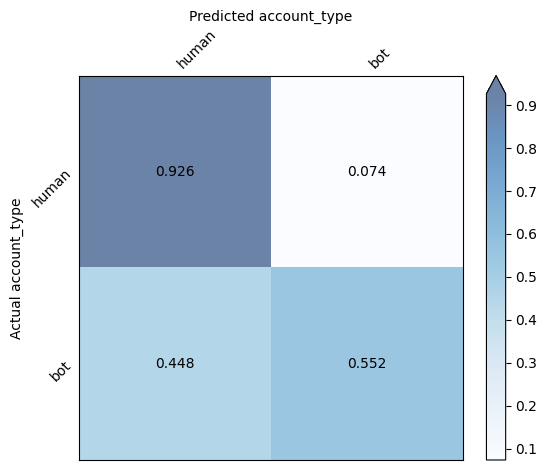

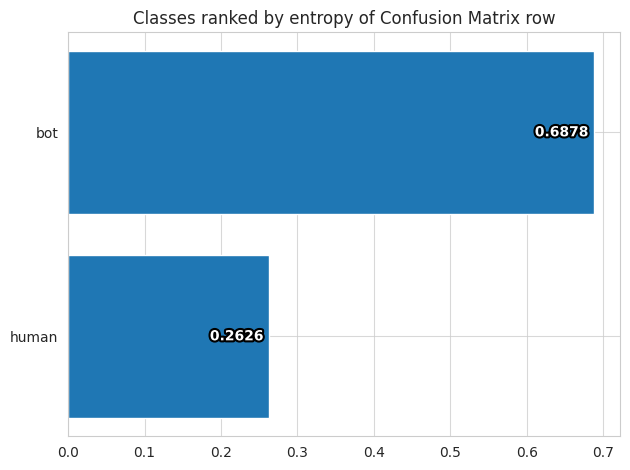

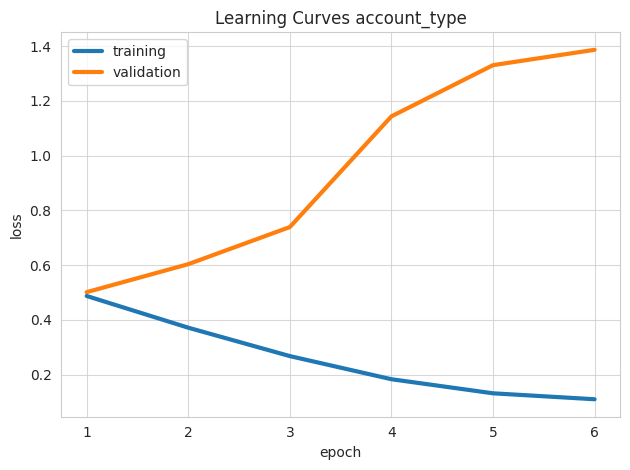

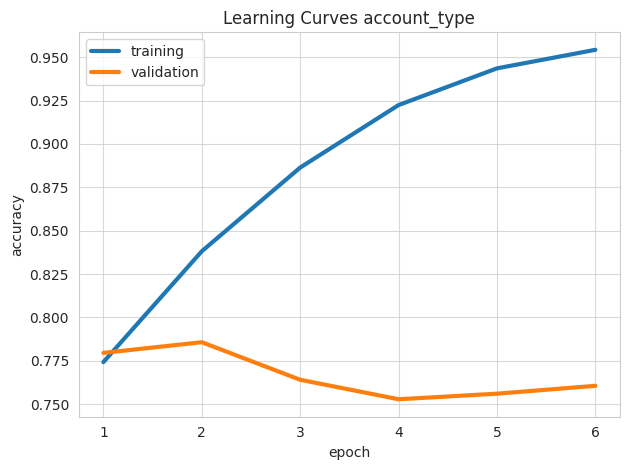

In [8]:
# Confusion matrix visualization for the binary classification

confusion_matrix(

  [test_stats],

  model.training_set_metadata,

  'account_type',

  top_n_classes=[2],

  model_names=[''],

  normalize=True,

)


# Learning curves to see model performance over epochs

learning_curves(train_stats, output_feature_name='account_type')

In [9]:
# Predict on the entire dataset

predictions = model.predict(dataset_df)


# Extract predictions for 'account_type'

df_out = predictions[0].account_type_predictions.to_frame()


# Add ID for tracking

df_out['ID'] = dataset_df['id']


# Save predictions to a CSV file

df_out.to_csv("predictions.csv", index=False)

/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1735: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1744: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/data/preprocessing.py:1735: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_cols[feature[COLUMN]] = dataset_cols[feature[COLUMN]].fillna(
/opt/conda/lib/python3.10/site-packages/ludwig/utils/image_utils.py:173: UserWarning: Failed to read image from PNG file. Original exception: Existing exports o

Prediction: 100%|██████████| 293/293 [00:05<00:00, 55.91it/s]
